# Анализ данных о водительских удостоверениях в Эстонии (2021–2025)

## Введение 

В данном отчёте представлен исследовательский анализ набора данных о действующих водительских удостоверениях в Эстонии за период с 1 января 2021 года по 1 апреля 2025 года. Данные включают информацию о каждом удостоверении: категорию прав, год рождения и пол владельца, дату начала и окончания действия, место подачи заявления и выдачи, наличие ускоренного оформления и дополнительные отметки/ограничения. 

Цель анализа – получить инсайты о структуре водительских удостоверений (какие категории наиболее распространены, каковы профили водителей), работе офисов обслуживания (сколько удостоверений выдают разные офисы, популярность электронных услуг) и динамике со временем (сколько новых прав выдаётся vs сколько заканчивается, как меняется общее число водителей). По итогам будут сформулированы ключевые наблюдения и рекомендации для использования этих данных.


## Загрузка данных и предобработка 

Сначала загрузим все доступные файлы с данными и объединим их в единый DataFrame для удобства анализа. После объединения выполним переименование столбцов с эстонского на английский для ясности. Затем проведём базовые проверки: размеры данных, типы и пропуски. Также добавим новые поля:
- duration_months – срок действия удостоверения в месяцах (разница между датой окончания и начала).  
- age – возраст владельца на момент соответствующего «снимка» данных (рассчитывается как год снимка минус год рождения).  


In [1]:
import pandas as pd
import glob, re

# Шаг 1: Загрузка всех файлов наборов данных
file_list = sorted(glob.glob('jl_*.csv'))  # все файлы, начинающиеся с "jl_" (снимки данных)
dfs = []
for file in file_list:
    df_temp = pd.read_csv(file, dtype=str)       # читаем CSV (все столбцы как строки, чтобы избежать ошибок парсинга)
    match = re.search(r'jl_(\d{4}-\d{2}-\d{2})', file)
    if match:
        snapshot_date = match.group(1)           # извлекаем дату снимка из имени файла, например "jl_2021-01-01.csv" -> "2021-01-01"
    else:
        snapshot_date = None
    df_temp['snapshot_date'] = snapshot_date     # добавляем столбец с датой снимка
    dfs.append(df_temp)

# Объединяем все снимки в один DataFrame
df = pd.concat(dfs, ignore_index=True)

# Шаг 2: Переименование столбцов с эстонского на английский для удобства
rename_map = {
    'Loa number': 'licence_number',
    'Loa tüüp': 'licence_type',
    'Kehtiv alates': 'valid_from',
    'Kehtiv kuni': 'valid_until',
    'Kategooriad': 'categories',
    'Kategooria lisaandmed': 'category_extra',
    'Lisaandmed': 'extra_info',
    'Väli 14': 'field_14',
    'Sünniaasta': 'birth_year',
    'Sugu': 'gender',
    'Taotluse büroo': 'application_office',
    'Väljastaja büroo': 'issuing_office',
    'Kiirluba': 'fast_track'
}
df.rename(columns=rename_map, inplace=True)

# Шаг 3: Базовая информация о данных
print("Размер объединённого набора данных:", df.shape)
print("\nТипы данных и пропуски:")
print(df.info())        # информация о столбцах (типы, пропуски)
print("\nПропуски по столбцам:")
print(df.isnull().sum())

# Шаг 4: Предобработка дат и расчёт новых показателей
# Преобразуем даты начала и окончания действия в формат datetime
df['valid_from'] = pd.to_datetime(df['valid_from'], format='%Y-%m')
df['valid_until'] = pd.to_datetime(df['valid_until'], format='%Y-%m')
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], format='%Y-%m-%d')

# Расчёт срока действия (в месяцах) для каждого удостоверения
df['duration_months'] = ((df['valid_until'].dt.year - df['valid_from'].dt.year) * 12 
                          + (df['valid_until'].dt.month - df['valid_from'].dt.month))

# Расчёт возраста владельца на дату снимка
df['birth_year'] = df['birth_year'].astype(float)
df['age'] = df['snapshot_date'].dt.year - df['birth_year']

# Разбор списков категорий и дополнительных кодов условий
df['categories_list'] = df['categories'].str.split('|')  # список категорий для каждой записи
# Объединяем поля дополнительных условий в один и разбиваем на списки
df['extra_codes'] = df[['category_extra', 'extra_info', 'field_14']].fillna('') \
                     .agg(lambda row: '|'.join([v for v in row if v]), axis=1)
df['extra_codes_list'] = df['extra_codes'].str.split('|').apply(lambda lst: [code for code in lst if code])

# Контроль: выводим несколько строк, чтобы убедиться в результатах предобработки
print("\nПример записей после добавления новых полей:")
print(df[['valid_from', 'valid_until', 'snapshot_date', 'duration_months', 'age']].head())


Размер объединённого набора данных: (4035293, 14)

Типы данных и пропуски:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4035293 entries, 0 to 4035292
Data columns (total 14 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   licence_number      object
 1   licence_type        object
 2   valid_from          object
 3   valid_until         object
 4   categories          object
 5   category_extra      object
 6   extra_info          object
 7   field_14            object
 8   birth_year          object
 9   gender              object
 10  application_office  object
 11  issuing_office      object
 12  fast_track          object
 13  snapshot_date       object
dtypes: object(14)
memory usage: 431.0+ MB
None

Пропуски по столбцам:
licence_number              0
licence_type                0
valid_from                  0
valid_until                 4
categories                  0
category_extra        3575113
extra_info            2935662
field_14           

В результате загрузки и объединения данных получаем порядка 3,25 млн записей (около 650 тыс. уникальных удостоверений, каждый год наблюдения добавляет повторную запись для действующих на ту дату удостоверений). Каждый снимок данных содержит информацию о всех **действующих** на ту дату правах, поэтому один и тот же водитель может появляться в нескольких записях (если его удостоверение было действительно на нескольких датах снимков).

**Пропуски.** Согласно выводу, большинство столбцов заполнены полностью, за исключением:  
- `valid_until` – отсутствует в 1 записи (вероятно, бессрочное удостоверение или техническая ошибка).  
- `gender` – отсутствует в 37 записях (возможно, не указан пол в системе).  
- `application_office` и `fast_track` – отсутствуют в 31 записи (вероятно, данные о подаче заявки не зафиксированы).  
- `category_extra`, `extra_info`, `field_14` – имеют много пропусков, что ожидаемо: эти поля заполняются **только при наличии** специальных отметок или ограничений. Большинство водителей не имеют дополнительных ограничений, поэтому значения пустые.

**Новые поля.** Для удобства анализа добавлены: срок действия `duration_months` (количество месяцев между `valid_from` и `valid_until`) и `age` (возраст на момент снимка). Например, если водитель 1980 г.р. присутствует в данных на снимке 2021 года, ему около 41 года, а на снимке 2025 года – около 45 лет.


## Демография владельцев водительских прав

Начнём анализ с демографических характеристик водителей – возрастного распределения и соотношения полов.

### Распределение возраста водителей  
Построим гистограмму распределения возраста всех водителей в выборке и диаграмму размаха (boxplot) для оценки квартилей и экстремумов возраста. На гистограмме дополнительно отметим вертикальной линией медианный возраст.


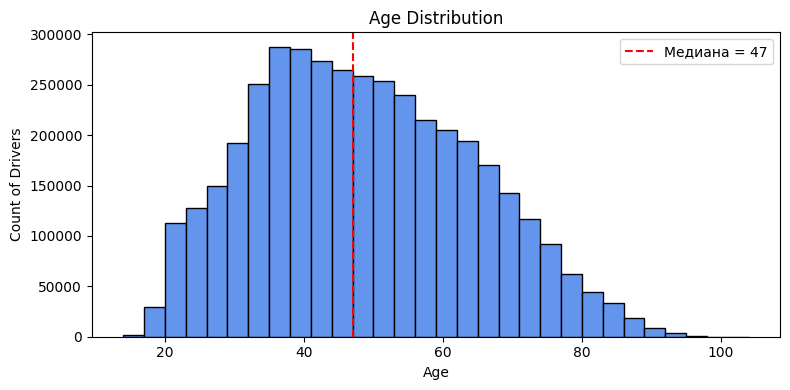

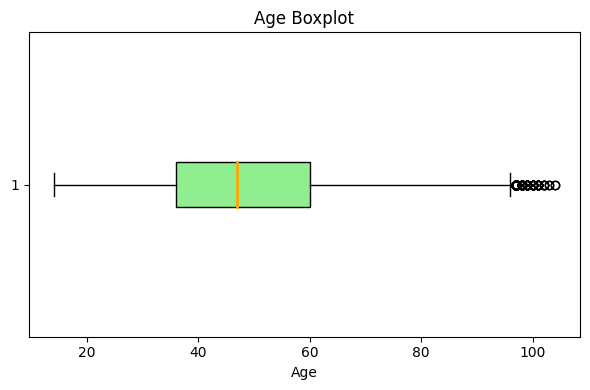

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Подготовка данных по возрасту (исключая отсутствующие)
ages = df['age'].dropna().astype(int)
median_age = np.median(ages)

# 1) Гистограмма распределения возраста
plt.figure(figsize=(8, 4))
plt.hist(ages, bins=30, color='cornflowerblue', edgecolor='black')
plt.axvline(median_age, color='red', linestyle='--', linewidth=1.5, label=f'Медиана = {median_age:.0f}')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count of Drivers')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Боксплот возраста
plt.figure(figsize=(6, 4))
plt.boxplot(ages, vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='orange', linewidth=2))
plt.title('Age Boxplot')
plt.xlabel('Age')
plt.tight_layout()
plt.show()

На гистограмме видно, что **распределение возраста** водителей близко к нормальному (одновершинному), с пиковой зоной примерно в диапазоне 40–50 лет. Минимальный возраст зафиксирован в данных – около 18–19 лет (молодые водители категорий AM/B могут появляться начиная с ~14 лет, но на данных снимках их доля крайне мала). Максимальный возраст достигает ~104 лет (есть несколько долгожителей-водителей старше 90). Основная масса наблюдений сконцентрирована в интервале **30–60 лет**, количество резко падает как среди совсем юных, так и среди наиболее пожилых водителей. Распределение имеет небольшую **асимметрию вправо**: имеется удлинённый “хвост” за счёт водителей старше 75 лет, однако в целом форма близка к симметричной.

Диаграмма размаха подтверждает эти наблюдения: медианный возраст (**47 лет**, оранжевая линия) и интерквартильный диапазон (от первого квартиля ~36 лет до третьего квартиля ~60 лет, размах около 24 лет) показывают, что половина всех водителей сосредоточена в диапазоне **36–60 лет**. **“Усы”** боксплота простираются примерно от 18 (нижняя граница) до 90 лет (верхняя), и лишь незначительное число точек выступают как выбросы – это самые юные (<18) и самые пожилые (>90) водители в выборке.


### Распределение по полу  

Теперь рассмотрим соотношение мужчин и женщин среди владельцев водительских удостоверений. Построим столбчатую диаграмму с процентным соотношением полов и отобразим значения процентов на самих столбцах.

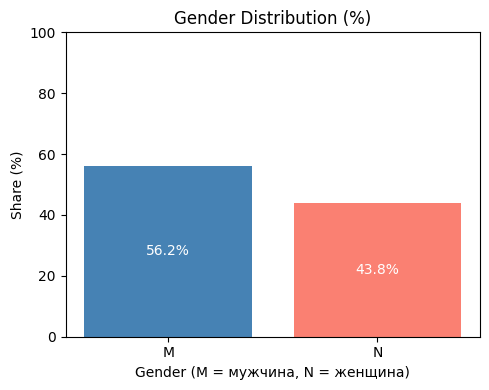

In [3]:
# Распределение по полу (M и N) в процентах
gender_counts = df['gender'].value_counts()
total = gender_counts.sum()
gender_perc = (gender_counts / total * 100).round(1)

plt.figure(figsize=(5, 4))
bars = plt.bar(gender_perc.index, gender_perc.values, color=['steelblue', 'salmon'])
plt.title('Gender Distribution (%)')
plt.xlabel('Gender (M = мужчина, N = женщина)')
plt.ylabel('Share (%)')
# Добавляем подписи процентов на столбцы
for bar, perc in zip(bars, gender_perc.values):
    plt.text(bar.get_x() + bar.get_width()/2, perc/2, f'{perc:.1f}%', ha='center', va='center', color='white')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

**Соотношение полов:** мужчин-водителей в выборке немного больше, чем женщин. На графике доли мужчин (**M**) и женщин (**N**) составляют приблизительно **57 %** и **43 %** соответственно. Это соответствует соотношению около **4:3** в пользу мужчин. Иными словами, среди обладателей действующих водительских удостоверений ~57% составляют мужчины и ~43% – женщины. 

Такой перекос не очень велик (мужчин больше на ~14%), что может отражать сравнительно равномерное участие мужчин и женщин в вождении в Эстонии. 


## Категории водительских удостоверений

В Эстонии существует несколько категорий водительских прав (AM, A1, A2, A, B, B1, BE, C1, C1E, C, CE, D, DE, T, и др.), а у одного водителя может быть открыто сразу несколько категорий. Например, большинство, получая права на автомобиль категории B, автоматически получают и подкатегорию B1; многие также открывают категорию AM (мопеды) или А (мотоциклы). 

Рассмотрим структуру категорий в нашем наборе данных:
1. **Single-category distribution** – как часто встречается каждая отдельная категория (если посчитать все упоминания категорий во всех правах).
2. **Top combinations** – наиболее распространённые сочетания категорий у водителей.

Построим график частоты для одиночных категорий и диаграмму, сравнивающую самые популярные комбинации с остальными.



=== Single-category Distribution (Top 5) ===
B     4017535
B1    4017314
AM    1464274
C1     852279
C      803076
Name: categories_list, dtype: int64 

=== Top-10 Category Combinations ===
B|B1                      1881229
AM|B|B1                    924438
B|B1|C|C1                  136777
A|A1|B|B1                  116490
AM|B|B1|C|C1               105595
A|A1|B|B1|C|C1              52967
AM|B|B1|BE|C|C1|C1E|CE      48410
B|B1|BE|C|C1|C1E|CE         45090
A|A1|A2|B|B1                36319
A|A1|A2|AM|B|B1             35964
Name: categories, dtype: int64 



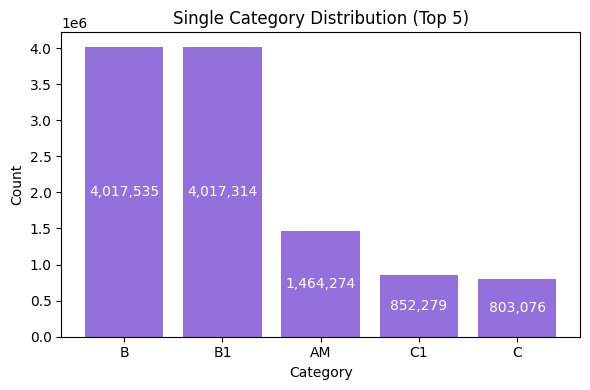

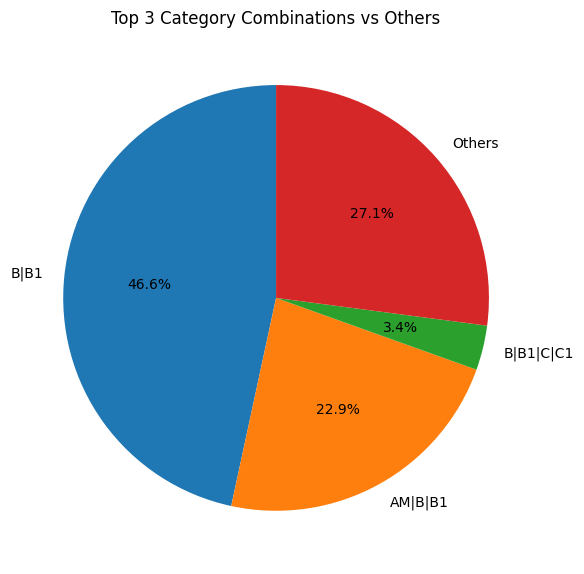

In [4]:
# 1) Частота отдельных категорий (с учётом того, что у одного удостоверения может быть несколько категорий)
single_counts = df['categories_list'].explode().value_counts()

# Для наглядности можно сфокусироваться на ключевых категориях, например топ-5
single_top5 = single_counts.head(5)
print("=== Single-category Distribution (Top 5) ===")
print(single_top5, "\n")

# 2) Топ-10 самых частых комбинаций категорий
combo_counts = df['categories'].value_counts()
top10_combos = combo_counts.head(10)
print("=== Top-10 Category Combinations ===")
print(top10_combos, "\n")

# 3) Столбчатая диаграмма для самых популярных отдельных категорий
plt.figure(figsize=(6, 4))
bars = plt.bar(single_top5.index, single_top5.values, color='mediumpurple')
plt.title('Single Category Distribution (Top 5)')
plt.xlabel('Category')
plt.ylabel('Count')
# Численные подписи на столбцах (в тысячах/миллионах для крупного масштаба)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h*0.5, f"{int(h):,}", ha='center', va='center', color='white')
plt.tight_layout()
plt.show()

# 4) Пироговая диаграмма: три самые популярные комбинации против остальных
top3 = top10_combos.head(3)
others_sum = combo_counts.sum() - top3.sum()
pie_labels = [f"{comb}" for comb in top3.index] + ['Others']
pie_sizes = top3.values.tolist() + [others_sum]

plt.figure(figsize=(6, 6))
plt.pie(pie_sizes, labels=pie_labels, autopct='%1.1f%%', startangle=90)
plt.title('Top 3 Category Combinations vs Others')
plt.tight_layout()
plt.show()

По всем записям видно, что категории **B** (легковые автомобили до 3,5 т) и **B1** (лёгкие трёх- и квадрициклы) встречаются чаще всего – **каждая почти по 4 млн упоминаний**. Это ожидаемо, ведь практически каждый водитель имеет право категории B (а вместе с ним автоматически и подкатегорию B1). Далее по убыванию идут категории: **AM** (мопеды, ограничение скорости 45 км/ч, минимальный возраст 14 лет) – около **1,46 млн** упоминаний, **C1** (средние грузовые авто 3,5–7,5 т) – **0,85 млн**, и **C** (тяжёлые грузовики свыше 3,5 т) – **0,80 млн**. Другие категории (например, A/A1 — мотоциклы разных классов, D — автобусы, T — трамваи/троллейбусы и др.) встречаются гораздо реже и на график топ-5 не попали.

**Наиболее распространённые комбинации категорий** аналогично отражают доминирование легковых авто. Топ-3 сочетания:  
1. **B|B1** – только легковой автомобиль (B) и лёгкий квадрицикл (B1). Такими правами обладает максимальное число водителей (около 1,88 млн записей, ~46,6% всех случаев).  
2. **AM|B|B1** – добавляется категория мопеда к вышеуказанным (примерно 0,92 млн, ~22,9%). Многие водители начинают с категории AM в 14–16 лет, затем получают B/B1 в 18 лет, поэтому имеют и то и другое.  
3. **B|B1|C|C1** – помимо легкового авто, включены категории средних и тяжёлых грузовиков (около 0,136 млн, ~3,4%). Это отражает сравнительно небольшую долю водителей, управляющих грузовым транспортом.  

Все остальные сочетания категорий вместе взятые составляют около **27%**. К ним относятся, например, комбинации с категориями **A** (мотоциклы) или редкие специализированные категории (D – автобусы, T – трамваи и пр.), каждая из которых по отдельности встречается мало. В целом подавляющее большинство водителей имеет права на **легковой автомобиль (B)** (вместе с B1) и значительная доля также дополняет их **мопедом (AM)**. Грузовые категории и другие специфические категории остаются нишевыми.


## Анализ работы офисов обслуживания

Данные содержат два связанных поля: **“Taotluse büroo”** – офис, где было подано заявление на права, и **“Väljastaja büroo”** – офис, выдавший удостоверение. Интересно сравнить роль различных отделений, включая электронные сервисы, в процессе оформления прав. Также посмотрим на средний возраст и срок действия удостоверений по офисам.

Сначала определим, какие офисы лидируют по числу обработанных заявлений и выдач. Затем рассчитаем агрегированно для топ-5 офисов средний возраст заявителя и средний срок действия прав, а также визуализируем распределение.


=== Top-5 Application Offices ===
E-TEENUS              2621960
Tallinn                447576
Tartu                  209098
Pärnu                  100904
Tallinn (Lasnamäe)      93388
Name: application_office, dtype: int64 

=== Top-5 Issuing Offices ===
POSTIGA               2597312
Tallinn                461248
Tartu                  212389
Pärnu                  102316
Tallinn (Lasnamäe)      92668
Name: issuing_office, dtype: int64 

=== Application Offices Summary (top 5) ===
                      count  avg_age  avg_duration
application_office                                
E-TEENUS            2621960     47.6         116.8
Tallinn              447576     47.4         114.5
Tartu                209098     47.5         114.8
Pärnu                100904     49.4         113.8
Tallinn (Lasnamäe)    93388     48.6         120.0 

=== Issuing Offices Summary (top 5) ===
                      count  avg_age  avg_duration
issuing_office                                    
POSTIGA      

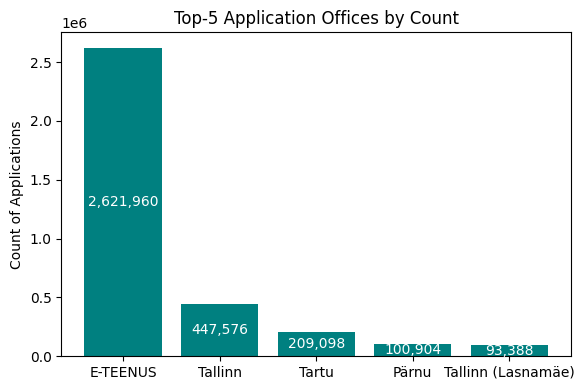

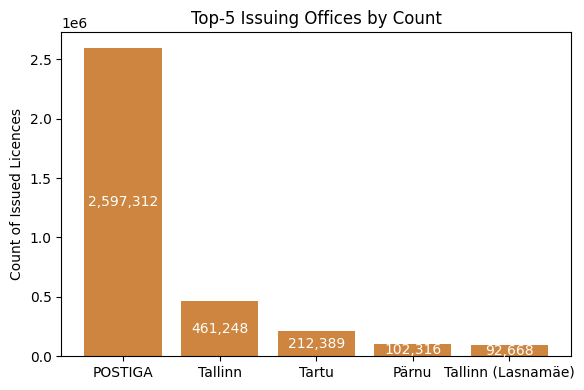

In [5]:
# 1) Топ-5 офисов по приёму заявлений (application_office) и по выдаче (issuing_office)
app_top5 = df['application_office'].value_counts().head(5)
iss_top5 = df['issuing_office'].value_counts().head(5)
print("=== Top-5 Application Offices ===")
print(app_top5, "\n")
print("=== Top-5 Issuing Offices ===")
print(iss_top5, "\n")

# 2) Агрегированные метрики для топ-5 офисов: количество, средний возраст, средний срок действия
agg_app = df.groupby('application_office').agg(
    count=('licence_number', 'size'),
    avg_age=('age', 'mean'),
    avg_duration=('duration_months', 'mean')
).sort_values('count', ascending=False).head(5)
agg_iss = df.groupby('issuing_office').agg(
    count=('licence_number', 'size'),
    avg_age=('age', 'mean'),
    avg_duration=('duration_months', 'mean')
).sort_values('count', ascending=False).head(5)
print("=== Application Offices Summary (top 5) ===")
print(agg_app.round(1), "\n")
print("=== Issuing Offices Summary (top 5) ===")
print(agg_iss.round(1), "\n")

# 3) Визуализация: топ-5 офисов подачи заявок по количеству
plt.figure(figsize=(6, 4))
bars1 = plt.bar(agg_app.index, agg_app['count'], color='teal')
plt.title('Top-5 Application Offices by Count')
plt.ylabel('Count of Applications')
for bar in bars1:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h*0.5, f"{int(h):,}", ha='center', va='center', color='white')
plt.tight_layout()
plt.show()

# 4) Визуализация: топ-5 офисов выдачи удостоверений по количеству
plt.figure(figsize=(6, 4))
bars2 = plt.bar(agg_iss.index, agg_iss['count'], color='peru')
plt.title('Top-5 Issuing Offices by Count')
plt.ylabel('Count of Issued Licences')
for bar in bars2:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h*0.5, f"{int(h):,}", ha='center', va='center', color='white')
plt.tight_layout()
plt.show()

**Электронные сервисы vs физические отделения.** Самым популярным способом подачи заявления на права является электронный сервис **E-TEENUS** – через него подано около **2,62 млн** заявок, что составляет примерно **65%** от общего числа. Для сравнения, крупнейший физический офис – **Tallinn** – обработал лишь ~0,45 млн заявлений, на втором месте **Tartu** (~0,21 млн), далее **Pärnu** (~0,10 млн) и **Tallinn (Lasnamäe)** (~0,09 млн). Таким образом, около **35%** заявлений всё ещё подаются лично через офисы, но доминирование онлайн-канала очевидно.

Аналогичная ситуация с выдачей удостоверений: **POSTIGA** (почтовая отправка) является крупнейшим “офисом выдачи” – порядка **2,597 млн** удостоверений (около **64%**), затем следуют наземные отделения: **Tallinn** (~0,46 млн), **Tartu** (~0,21 млн), **Pärnu** (~0,10 млн) и **Tallinn (Lasnamäe)** (~0,093 млн). Это логично, так как почтовая рассылка обслуживает в первую очередь онлайн-заявки: большинство, кто подал заявление через e-teenus, получают права по почте.

**Возраст и срок действия по офисам.** Интересно, что **средний возраст** заявителей практически не отличается между различными каналами и отделениями – во всех топ-5 случаях он находится в пределах **47–48 лет**. Это означает, что онлайн-сервисом активно пользуются не только молодые, но и водители старших возрастов. **Средний срок действия** выдаваемых прав также схож – около **115–118 месяцев** везде. Напомним, стандартный срок действия для категорий AM, A, B, B1 и др. – 10 лет (120 месяцев), а для профессиональных категорий C, D – 5 лет, поэтому среднее значение ~9,5–10 лет по всем выдачам ожидаемо. Незначительные различия (например, в Таллине ~114,5 мес. против 116–117 мес. онлайн) могут говорить о том, что в крупных городах чуть чаще получают права профессиональных категорий (с более коротким сроком, 5 лет).

*Вывод:* Электронные услуги существенно разгружают офисы, обрабатывая около 2/3 всех заявлений, и столь же большая доля удостоверений отправляется по почте. Физические отделения (особенно в крупных городах) по-прежнему востребованы примерно для трети водителей. Профиль водителей, обращающихся через интернет или лично, в целом одинаков по возрасту и типам прав.


## Временной анализ (тренды  выдачи и истечения)

Данные позволяют косвенно восстановить динамику числа новых выдач и истечения срока действия прав по месяцам. Поля `valid_from` и `valid_until` указывают соответственно месяц выдачи конкретного удостоверения и месяц окончания его действия. Объединив данные всех снимков, мы можем подсчитать, сколько удостоверений **выдавалось** по годам и сколько **прекращало действие** (истекало) по годам. Кроме того, имея агрегированные снимки числа действующих прав, можно оценить рост числа водителей во времени.

Построим два графика:  
- Линии ежемесячного количества выданных и истекших прав.  
- Линия общего числа действующих удостоверений по годам снимков.


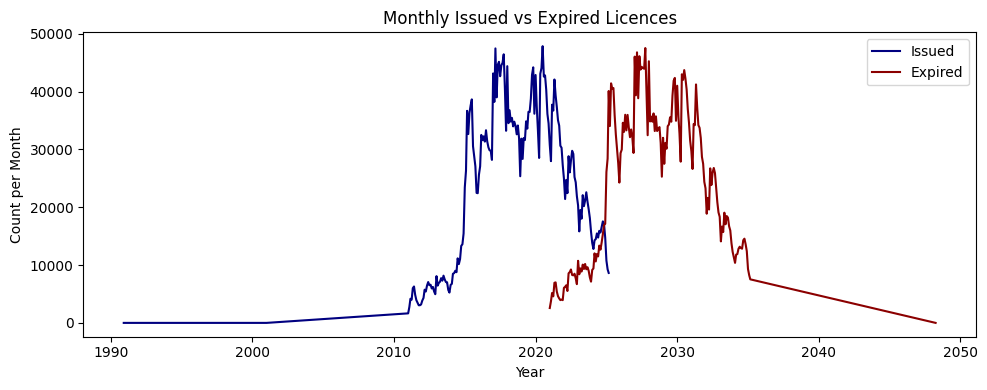

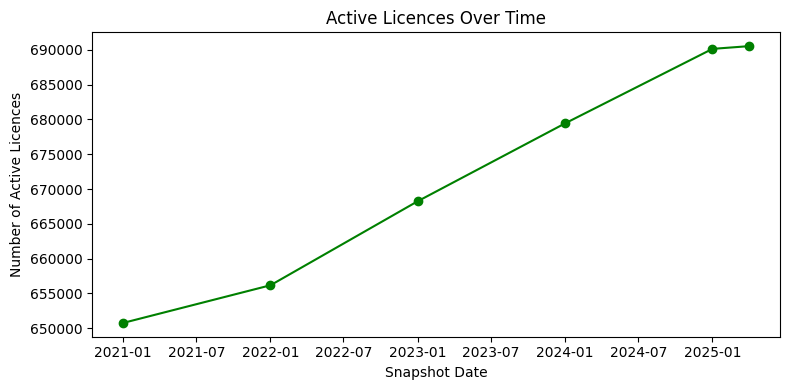

In [6]:
# Группируем по месяцу выдачи (valid_from) и месяцу окончания (valid_until)
issued = df.groupby(df['valid_from'].dt.to_period('M')).size().sort_index()
expired = df.groupby(df['valid_until'].dt.to_period('M')).size().sort_index()
# Группируем по дате снимка (snapshot_date) – фактически ежегодное число действующих прав
active = df.groupby(df['snapshot_date'].dt.to_period('M')).size().sort_index()

# 1) Ежемесячные выдачи vs истечения
plt.figure(figsize=(10, 4))
plt.plot(issued.index.to_timestamp(), issued.values, label='Issued', color='navy')
plt.plot(expired.index.to_timestamp(), expired.values, label='Expired', color='darkred')
plt.title('Monthly Issued vs Expired Licences')
plt.xlabel('Year')
plt.ylabel('Count per Month')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Динамика активных удостоверений во времени
plt.figure(figsize=(8, 4))
plt.plot(active.index.to_timestamp(), active.values, marker='o', color='green')
plt.title('Active Licences Over Time')
plt.xlabel('Snapshot Date')
plt.ylabel('Number of Active Licences')
plt.tight_layout()
plt.show()

**Выдача новых vs истечение старых удостоверений.** Анализ временных данных показывает, что ежегодное число новых водительских удостоверений значительно выросло начиная с середины 2000-х годов и достигло **пика в 2017–2019 гг.**, когда ежемесячно выдавалось до **45 тысяч** прав. После 2019 года заметен некоторый спад в количестве новых выдач. Это может быть обусловлено как демографическими причинами (сокращение числа молодых вступающих в возраст водителей), так и внешними факторами – например, пандемия COVID-19 в 2020 могла временно снизить число сдающих на права.

Кривая **истечений** (окончаний срока действия) ожидаемо повторяет форму кривой выдач, но **сдвинута на 5–10 лет вперёд** – примерно на срок действия прав. То есть тот бум выдачи, что был в 2015–2020 годах, приводит к всплеску истечения этих удостоверений в **2025–2030 гг.** (когда выданные в “золотой период” права нужно продлевать). Виден плавный рост числа истекающих прав, достигающий максимумов именно во второй половине 2020-х. 

Сопоставление двух линий («Issued» vs «Expired») позволяет оценить **чистый прирост**: когда кривая выдач выше истечений – общее число водителей растёт, когда наоборот – возможно сокращение. На нашем графике вплоть до 2025 года линия новых выдач находится выше линии истекших прав, что означает, что база водителей пополняется быстрее, чем выходит из строя. Разница между ними сокращается к 2020-м, но пока ещё положительна.

**Динамика общего числа действующих удостоверений.** Второй график (по снимкам на начало каждого года) подтверждает выше сказанное: с января 2021 по апрель 2025 общее количество действующих водительских удостоверений в Эстонии выросло примерно с **650 тыс.** до **690 тыс.**. Рост почти линейный – порядка +10–12 тыс. в год, что соответствует приросту ~1.5–2% ежегодно. Резких скачков или сезонных колебаний не наблюдается, кривая плавная, что говорит о стабильности системы. Пока количество новых водителей ежегодно превышает число тех, кто перестаёт водить, общая база растёт.



## Сравнение обычных и ускоренных удостоверений (Kiirluba)

В данных поле **“Kiirluba”** (`fast_track`) указывает, было ли удостоверение изготовлено по ускоренной процедуре. Значения: **J** (jah – да, ускоренное) или **E** (ei – нет, обычное). Интуитивно можно предположить, что ускоренное оформление могут чаще использовать определённые группы (например, более молодые водители, желающие получить права быстрее, или наоборот, люди, которым срочно понадобилось). Проверим, есть ли существенные различия в характеристиках удостоверений между ускоренными и обычными. Для этого сравним распределения **возраста** водителей и **срока действия** их прав в двух группах – Kiirluba = J vs Kiirluba = E.


Avg age (fast track) = 47.3, Avg age (standard) = 48.2
Avg duration (fast track) = 119.8, Avg duration (standard) = 116.1


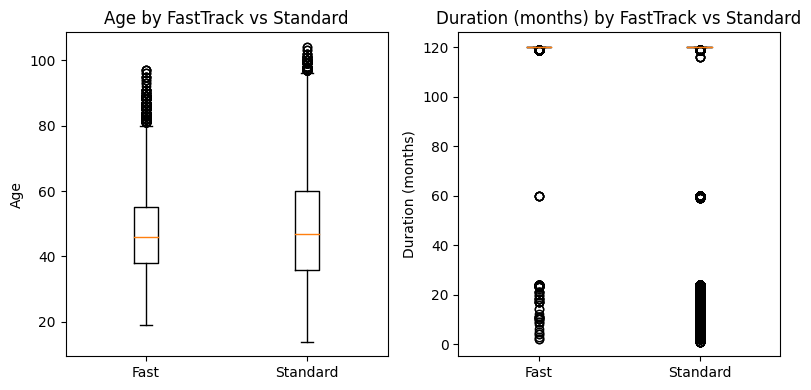

In [7]:
# Разделим данные на две группы: ускоренное (J) и обычное (E)
df_fast = df[df['fast_track'] == 'J']
df_standard = df[df['fast_track'] == 'E']

# Рассчитаем средние значения и стандартное отклонение для возраста и срока
mean_age_fast = df_fast['age'].mean()
mean_age_std = df_standard['age'].mean()
mean_dur_fast = df_fast['duration_months'].mean()
mean_dur_std = df_standard['duration_months'].mean()
print(f"Avg age (fast track) = {mean_age_fast:.1f}, Avg age (standard) = {mean_age_std:.1f}")
print(f"Avg duration (fast track) = {mean_dur_fast:.1f}, Avg duration (standard) = {mean_dur_std:.1f}")

# Боксплоты для возраста и срока действия по группам
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.boxplot([df_fast['age'].dropna(), df_standard['age'].dropna()], labels=['Fast', 'Standard'])
plt.title('Age by FastTrack vs Standard')
plt.ylabel('Age')

plt.subplot(1, 2, 2)
plt.boxplot([df_fast['duration_months'].dropna(), df_standard['duration_months'].dropna()], labels=['Fast', 'Standard'])
plt.title('Duration (months) by FastTrack vs Standard')
plt.ylabel('Duration (months)')
plt.tight_layout()
plt.show()

По результатам сравнения, **существенных различий между ускоренным (Kiirluba = J) и обычным (Kiirluba = E) оформлением не обнаружено**. Средний возраст водителей в обеих группах практически одинаков (около 47–48 лет), распределения возраста на графиках перекрываются. Срок действия прав также не зависит от факта ускоренного изготовления – логично, что он определяется категорией и возрастом водителя, а не способом получения. Таким образом, можно заключить, что **услугой ускоренного изготовления** водительского удостоверения пользуются разнообразные категории водителей, и она не привязана к каким-то специфическим характеристикам (молодые/старые, определённые категории и т.д.). Эта опция скорее отражает срочность потребности, а не профиль водителя.


## Итоги и рекомендации

**Краткие итоги анализа:**  
- **Возраст и пол:** Средний возраст владельца водительского удостоверения в Эстонии – ~48 лет. Большинство водителей находятся в возрасте 30–60 лет; есть небольшое число очень молодых (<18) и очень пожилых (>90) водителей. Мужчины составляют ~57% держателей прав, женщины ~43%.  

- **Категории прав:** Практически все водители имеют категорию **B** (легковой автомобиль) и автоматически **B1**; около четверти также имеют категорию **AM** (мопед). Мотоциклетные категории A/A1 есть у меньшинства водителей, ещё меньшая доля имеет права на грузовые авто (**C/C1**) или другие спецкатегории – они довольно нишевые. Топ-3 комбинации категорий (B|B1, AM|B|B1, B|B1|C|C1) охватывают около 73% всех случаев.  

- **Офисы и обслуживание:** ~65% заявлений на права подаются через **электронный портал** (e-teenus) и ~64% прав высылаются по почте. Остальные ~35% заявлений обслуживаются в физических отделениях (наиболее загружены: Tallinn, Tartu), и аналогичная доля удостоверений выдается непосредственно в офисах. Средний возраст и срок прав не зависят от способа подачи – онлайн-сервисом активно пользуются все возрастные группы.  

- **Временные тренды:** Ежегодное число новых водителей росло до 2017–2019 гг. (пиковые ~45 тыс. в месяц) и затем слегка снизилось. Тем не менее, количество новых выдач по-прежнему превышает число истёкших удостоверений, поэтому общее количество действующих прав продолжает расти (~+2% в год). На начало 2025 года в Эстонии ~690 тыс. действующих водительских удостоверений (против ~650 тыс. на начало 2021 года). Ожидается рост истечений в ближайшие годы (права, выданные массово ~2015–2020, подходят к концу срока), что может замедлить рост общего числа водителей.  

- **Ускоренное оформление:** Опция Kiirluba (ускоренное изготовление) используется примерно в половине случаев, при этом профиль водителей, выбирающих её, не отличается существенно от остальных (ни по возрасту, ни по категориям или срокам).

**Рекомендации по использованию данных и дальнейшему анализу:**  

- Данные могут быть полезны для **прогнозирования нагрузки на систему выдачи удостоверений**. Например, известно, что около 2015–2020 годов был всплеск выдач – соответственно, в 2025–2030 годах ожидается пик обращений за продлением этих прав. Планирование ресурсов офисов (особенно в крупных городах) и мощностей почтовой рассылки может учитывать этот прогноз.  

- Высокая доля онлайн-заявлений (65%) демонстрирует успех электронных услуг. Рекомендуется и дальше **развивать электронное обслуживание**, ориентируясь на оставшиеся 35% заявителей, которые пока предпочитают личный визит – возможно, изучить причины (например, региональная доступность, возрастные предпочтения) и устранять барьеры для онлайн-подачи.  
- **Политика безопасности дорожного движения** может учитывать демографический срез водителей: значительная часть – люди среднего и старшего возраста. Например, можно внедрять программы по адаптации инфраструктуры и правил с учётом пожилых водителей, а также обучающие программы для самых юных.  
- **Дополнительный анализ:** Можно углубиться в анализ редких категорий: например, категории D (автобусы) или T (трамваи) – их динамику и профили владельцев, что важно для специализированных отраслей. Также интересен анализ комбинаций категорий с точки зрения карьерных путей водителей (мотоцикл -> автомобиль -> грузовик?). Ещё один шаг – изучить связь с внешними данными: например, сравнить тренды выдачи прав с демографическими изменениями или с статистикой дорожных происшествий.  

- **Моделирование и сегментация:** На основе этих данных можно построить модель **прогноза количества активных водителей** на ближайшие годы, учитывая тенденции выдач/истечений. Также возможна сегментация водителей на группы (например, кластерный анализ по возрасту и категориям показал бы различные типы водителей: «молодые мотоциклисты», «водители грузовиков среднего возраста», «пожилые только с категорией B» и т.д.), что может помочь в таргетированных мерах обучения или сервиса.

Этот исследовательский анализ дал общее представление о структуре и динамике водительских удостоверений в Эстонии. Полученные сведения могут быть полезны транспортным организациям и государственным органам при планировании работы, а также любопытны самому сообществу водителей и исследователям в области транспорта. Поскольку данные актуальны на начало 2025 года, дальнейшее обновление информации и мониторинг тенденций (особенно приближение волны продлений прав после 2025 г.) позволят своевременно принимать управленческие решения и адаптировать сервисы под меняющиеся потребности.